## 5-YEAR ACS SOCIOECONOMIC DATA BY TRACTS
Extract socioeconomic data from US Census' 5-year American Community Survey (ACS) in 2022.

In [1]:
# Modules.
import cenpy
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import pygris

In [2]:
# Paths.
acs_dir = Path("data/acs")
acs_dir.mkdir(parents = True, exist_ok = True)

output_file = acs_dir / "acs_socioeconomic_tract_2022.csv"

In [3]:
# Connect to ACS 2022 5-year table.
api = cenpy.remote.APIConnection("ACSDT5Y2022")

# NYC counties.
nyc_counties = ["005", "047", "061", "081", "085"]

# ACS variables.
acs_variables = {
    # Core.
    "total_pop": "B01003_001E",
    "median_income": "B19013_001E",
    "poverty_all": "B17001_001E",
    "poverty_count": "B17001_002E",
    "no_vehicle_hh": "B25044_003E",
    "white": "B02001_002E",

    # Education.
    "edu_bachelors": "B15003_022E",
    "edu_masters": "B15003_023E",
    "edu_professional": "B15003_024E",
    "edu_doctorate": "B15003_025E",
    "edu_total": "B15003_001E",

    # Housing tenure.
    "owner_hh": "B25003_002E",
    "renter_hh": "B25003_003E",
    "hh_total": "B25003_001E",

    # Limited English.
    "limited_english": "B16005_007E", 
    "limited_english_total": "B16005_001E"
}

cols = ["NAME"] + list(acs_variables.values())

In [4]:
# Download ACS for all NYC counties at the tract level.
records = []

for county in nyc_counties:
    print(f"Downloading ACS for county {county}.")

    df = api.query(
        cols = cols,
        geo_unit = "tract",
        geo_filter = {"state": "36", "county": county}
    )

    records.append(df)

acs = pd.concat(records, ignore_index = True)

In [5]:
# Construct GEOID.
acs["GEOID"] = acs["state"] + acs["county"] + acs["tract"]

In [6]:
# Rename ACS columns.
rename_map = {v: k for k, v in acs_variables.items()}

acs = acs.rename(columns = rename_map)

In [7]:
# Convert to numeric and fix ACS placeholders for unknown data.

placeholders = [
    -666666666, -888888888, -222222222, -333333333,
    -666666666.0, -888888888.0, -222222222.0, -333333333.0,
]

acs = acs.replace(placeholders, np.nan)

for col in acs_variables.keys():
    acs[col] = pd.to_numeric(acs[col], errors = "coerce")

In [8]:
# Remove non-residential tracts.
acs = acs[acs["total_pop"] >= 50].copy()

In [9]:
# NYC tracts.
nyc_tracts = pygris.tracts(state = "NY", county = nyc_counties, year = 2022)
nyc_tracts = nyc_tracts.to_crs("EPSG:2262")

# Merge to data.
acs = nyc_tracts.merge(acs, on = "GEOID", how = "inner")

Using FIPS code '36' for input 'NY'


In [10]:
nyc_tracts.crs

<Projected CRS: EPSG:2262>
Name: NAD83 / New York West (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Allegany; Cattaraugus; Chautauqua; Erie; Genesee; Livingston; Monroe; Niagara; Orleans; Wyoming.
- bounds: (-79.77, 41.99, -77.36, 43.64)
Coordinate Operation:
- name: SPCS83 New York West zone (US survey foot)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

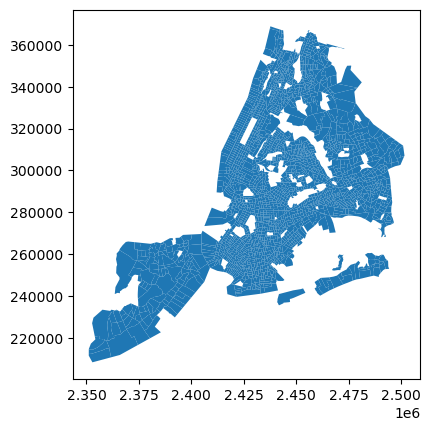

In [11]:
# Check plot.
acs.plot()

In [12]:
acs.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'NAME_y', 'total_pop', 'median_income', 'poverty_all',
       'poverty_count', 'no_vehicle_hh', 'white', 'edu_bachelors',
       'edu_masters', 'edu_professional', 'edu_doctorate', 'edu_total',
       'owner_hh', 'renter_hh', 'hh_total', 'limited_english',
       'limited_english_total', 'state', 'county', 'tract'],
      dtype='object')

In [13]:
# Feature engineering.

# Population density.
acs["pop_density"] = acs["total_pop"] / acs.geometry.area
acs["pct_non_white"] = (acs["total_pop"] - acs["white"]) / acs["total_pop"]

# Poverty rate.
acs["poverty_rate"] = acs["poverty_count"] / acs["poverty_all"]
acs["poverty_rate"] = acs["poverty_rate"].replace([np.inf, -np.inf], np.nan)

# Centered version.
# Transforms from raw proportion to centered (mean-subtracted) variable.
# Helps with interpretation. Can also be an interaction term with extreme heat to stabilize.
#acs["poverty_rate_c"] = acs["poverty_rate"] - acs["poverty_rate"].mean()

# Education.
acs["edu_bachelors_plus"] = (
    acs["edu_bachelors"] +
    acs["edu_masters"] +
    acs["edu_professional"] +
    acs["edu_doctorate"]
)

acs["pct_bachelors_plus"] = acs["edu_bachelors_plus"] / acs["edu_total"]
acs["pct_bachelors_plus"] = acs["pct_bachelors_plus"].replace([np.inf, -np.inf], np.nan)

# Housing tenure.
acs["pct_renters"] = acs["renter_hh"] / acs["hh_total"]
acs["pct_renters"] = acs["pct_renters"].replace([np.inf, -np.inf], np.nan)

# Limited English proficiency.
acs["pct_limited_english"] = acs["limited_english"] / acs["limited_english_total"]
acs["pct_limited_english"] = acs["pct_limited_english"].replace([np.inf, -np.inf], np.nan)

In [14]:
acs.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'NAME_y', 'total_pop', 'median_income', 'poverty_all',
       'poverty_count', 'no_vehicle_hh', 'white', 'edu_bachelors',
       'edu_masters', 'edu_professional', 'edu_doctorate', 'edu_total',
       'owner_hh', 'renter_hh', 'hh_total', 'limited_english',
       'limited_english_total', 'state', 'county', 'tract', 'pop_density',
       'pct_non_white', 'poverty_rate', 'edu_bachelors_plus',
       'pct_bachelors_plus', 'pct_renters', 'pct_limited_english'],
      dtype='object')

In [15]:
acs_final = acs.drop(['STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME_x', 'NAMELSAD',
                      'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
                      'geometry', 'NAME_y', 'poverty_all', 'poverty_count', 'edu_bachelors',
                      'edu_masters', 'edu_professional', 'edu_doctorate', 'edu_total',
                      'owner_hh', 'renter_hh', 'limited_english', 'limited_english_total',
                      'state', 'county', 'tract', 'edu_bachelors_plus', 'white'],
                      axis = 1)

In [16]:
acs_final.columns

Index(['GEOID', 'total_pop', 'median_income', 'no_vehicle_hh', 'hh_total',
       'pop_density', 'pct_non_white', 'poverty_rate', 'pct_bachelors_plus',
       'pct_renters', 'pct_limited_english'],
      dtype='object')

In [17]:
# Impute missing values.
# Only a handful should be missing, fix by tract median or global median.
for col in [
    "pct_bachelors_plus", "pct_renters", "pct_limited_english"
]:
    acs_final[col] = acs_final.groupby("GEOID")[col].transform(
        lambda x: x.fillna(x.median())
    )
    acs_final[col] = acs_final[col].fillna(acs_final[col].median())

In [18]:
# Save.
acs_final.columns = acs_final.columns.str.upper()

acs_final.to_csv(output_file, index = False)
print("Saved:", output_file)

acs_final.head()

Saved: data\acs\acs_socioeconomic_tract_2022.csv


,GEOID,TOTAL_POP,MEDIAN_INCOME,NO_VEHICLE_HH,HH_TOTAL,POP_DENSITY,PCT_NON_WHITE,POVERTY_RATE,PCT_BACHELORS_PLUS,PCT_RENTERS,PCT_LIMITED_ENGLISH
0,36081045000,2004,137109,35,761,0.001056,0.842315,0.069860,0.406198,0.540079,0.000000
1,36081045400,4793,65610,306,1696,0.001920,0.976633,0.188608,0.448410,0.592571,0.000000
2,36081045500,13869,75033,0,4482,0.008659,0.767395,0.211639,0.261328,1.000000,0.001110
3,36081045600,1244,75500,22,408,0.000710,0.881029,0.091640,0.434879,0.098039,0.000000
4,36081044602,5210,44700,45,1550,0.002835,0.868714,0.304574,0.270916,0.856774,0.012887
